#**Dataset Processing**

In [ ]:
import string
from collections import Counter
import math
from datasets import concatenate_datasets
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

**Load Dataset**

In [ ]:
from datasets import load_dataset
ds = load_dataset("dlwh/wikitext_2_detokenized")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


data/train/train.jsonl.zst:   0%|          | 0.00/3.38M [00:00<?, ?B/s]

data/validation/validation.jsonl.zst:   0%|          | 0.00/365k [00:00<?, ?B/s]

data/test/test.jsonl.zst:   0%|          | 0.00/406k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23767 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2461 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2891 [00:00<?, ? examples/s]

In [ ]:
ds['train']['text'][0]

' = Valkyria Chronicles III =\n'

In [ ]:
print(f"Length of Training set: {len(ds['train']['text'])}")
print(f"Length of Validation set: {len(ds['validation']['text'])}")
print(f"Length of Test set: {len(ds['test']['text'])}")

Length of Training set: 23767
Length of Validation set: 2461
Length of Test set: 2891


**Find Empty Sentences in Dataset**

In [ ]:
def empty_sentence(dataset):
  count = 0
  for sentence in dataset:
    if not sentence.strip(): # This checks if the string is empty or contains only whitespace
      count += 1
  return count

In [ ]:
print(f"No. of Empty sentences in Training set: {empty_sentence(ds['train']['text'])}")
print(f"No. of Empty sentences in Validation set: {empty_sentence(ds['validation']['text'])}")
print(f"No. of Empty sentences in Test set: {empty_sentence(ds['test']['text'])}")

No. of Empty sentences in Training set: 0
No. of Empty sentences in Validation set: 0
No. of Empty sentences in Test set: 0


**Find Heading Count in Dataset**

In [ ]:
def headings_count(dataset):
  count = 0
  for sentence in dataset:
    if sentence.strip()[0] == "=": # This checks if the string is a heading as headings begin with "="
      count += 1
  return count

In [ ]:
print(f"No. of Headings in Training set: {headings_count(ds['train']['text'])}")
print(f"No. of Headings in Validation set: {headings_count(ds['validation']['text'])}")
print(f"No. of Headings in Test set: {headings_count(ds['test']['text'])}")

No. of Headings in Training set: 6211
No. of Headings in Validation set: 620
No. of Headings in Test set: 708


**Combine Datasets into a single list**

In [ ]:

ds['combined'] = concatenate_datasets([ds['train'], ds['validation'], ds['test']])

In [ ]:
ds['combined']

Dataset({
    features: ['text'],
    num_rows: 29119
})

**Remove Headings**

In [ ]:
def remove_headings(dataset):
  new_list = []
  for sentence in dataset:
    cleaned_sentence = sentence.strip()
    if cleaned_sentence and not cleaned_sentence.startswith("="):
      new_list.append(cleaned_sentence.lower())

  return new_list


In [ ]:
training_set = remove_headings(ds['combined']['text'])

In [ ]:
len(training_set)

21580

**Cleaning**

Remove '-'

In [ ]:
training_set[0]

'senjō no valkyria 3: unrecorded chronicles (japanese: 戦場のヴァルキュリア3, lit. valkyria of the battlefield 3), commonly referred to as valkyria chronicles iii outside japan, is a tactical role-playing video game developed by sega and media.vision for the playstation portable. released in january 2011 in japan, it is the third game in the valkyria series. employing the same fusion of tactical and real-time gameplay as its predecessors, the story runs parallel to the first game and follows the "nameless", a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit "calamaty raven".'

In [ ]:
def clean_up(dataset):
  for index, sentence in enumerate(dataset):
    dataset[index] = dataset[index].translate(str.maketrans('-', ' '))

In [ ]:
clean_up(training_set)

In [ ]:
training_set[10]

"the majority of material created for previous games, such as the blitz system and the design of maps, was carried over. alongside this, improvements were made to the game's graphics and some elements were expanded, such as map layouts, mission structure, and the number of playable units per mission. a part of this upgrade involved creating unique polygon models for each character's body. in order to achieve this, the cooperative elements incorporated into the second game were removed, as they took up a large portion of memory space needed for the improvements. they also adjusted the difficulty settings and ease of play so they could appeal to new players while retaining the essential components of the series' gameplay. the newer systems were decided upon early in development. the character designs were done by raita honjou, who had worked on the previous valkyria chronicles games. when creating the nameless squad, honjou was faced with the same problem he had had during the first game

In [ ]:
headings_count(training_set)

0

In [ ]:
empty_sentence(training_set)

0

**Tokenization**

In [ ]:
def tokenization(dataset):
  counter = Counter()
  all_tokens = []
  for sentence in dataset:
    token = sentence.split()
    all_tokens.append(token)
    counter.update(token)
  return (counter, all_tokens)

In [ ]:
word_count, all_tokens = tokenization(training_set)

In [ ]:
len(word_count)

145192

In [ ]:
len(all_tokens)

21580

In [ ]:
#word_count.most_common()

**Filter Words based on Threshold**

In [ ]:
def filter_least_frequent_words(counter):
  sorted_word_count = sorted(counter.items(), key=lambda item: item[1])
  least_frequent_words = []
  for item in sorted_word_count:
    if item[1] < 5:
      least_frequent_words.append(item[0])
  return least_frequent_words

In [ ]:
least_frequent_words = filter_least_frequent_words(word_count)

In [ ]:
len(least_frequent_words)

115412

**Remove Least Frequent Words**

In [ ]:
def remove_least_frequent_words(list_of_token_lists):
  # Convert least_frequent_words to a set for O(1) average time complexity lookups
  least_frequent_words_set = set(least_frequent_words)
  updated_all_tokens = []

  for token_list in list_of_token_lists:
    updated_tokens_for_sentence = []
    for word in token_list:
      if word not in least_frequent_words_set:
        updated_tokens_for_sentence.append(word)
    updated_all_tokens.append(updated_tokens_for_sentence)

  return updated_all_tokens

In [ ]:
training_token_list = remove_least_frequent_words(all_tokens)

In [ ]:
#training_token_list[0]

In [ ]:
len(training_token_list)

21580

In [ ]:
def calculate_word_count(list_of_tokens):
  counter_1 = Counter()

  for item in list_of_tokens:
    counter_1.update(item)
  return (counter_1)

In [ ]:
updated_word_count = calculate_word_count(training_token_list) #counter

In [ ]:
len(sorted(updated_word_count.items(), key=lambda item: item[1]))

29780

In [ ]:
sorted(updated_word_count.items(), key=lambda item: item[1])[0]

('senjō', 5)

**Create Word Index**

In [ ]:
sorted_vocabulary = sorted(updated_word_count.items(), key=lambda item: -item[1])

In [ ]:
word2idx = {word: idx for idx, (word, _) in enumerate(sorted_vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

#**Token Reduction Implementation**

**1️⃣ Compute total_tokens_after_filtering**

In [ ]:
total_tokens_after_filtering = sum(updated_word_count.values())
print(f"Total tokens after filtering: {total_tokens_after_filtering}")

Total tokens after filtering: 1935519


**2️⃣ Compute normalized frequency f(w)**

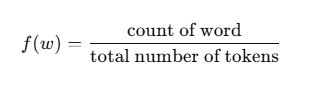

In [ ]:
normalized_word_frequency = {word: count/ total_tokens_after_filtering for word, count in updated_word_count.items()}

In [ ]:
normalized_word_frequency['the']

0.08247141981039711

**3️⃣ Compute discard probability per word**

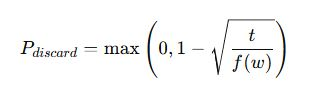

In [ ]:
t = 10**-5 #hyperparameter

In [ ]:
def discard_probability(f_w):
  p_discard = max(0, 1 - math.sqrt(t/f_w))
  return p_discard

In [ ]:
discard_probability_per_word = {word: discard_probability(f_w) for word, f_w in normalized_word_frequency.items()}

In [ ]:
discard_probability_per_word['senjō']

0

**4️⃣ Rebuild corpus using random filtering**

Generate random number r ∈ [0,1]

If r > P_discard(word) → keep word

Else → drop word


In [ ]:
subsampled_sentence_tokens = []

# Set a random seed for reproducibility
random.seed(42)

for sentence_tokens in training_token_list: #iterate over lists of tokens
    new_sentence = []
    for word in sentence_tokens:
        if random.random() > discard_probability_per_word[word]:
            new_sentence.append(word)

    if len(new_sentence) >= 2:  #if less than 2 word pairs cannot be formed
        subsampled_sentence_tokens.append(new_sentence)

In [ ]:
len(subsampled_sentence_tokens)

20475

In [ ]:
subsampled_sentence_tokens[1]

['game',
 'work',
 'chronicles',
 'ii.',
 'retained',
 'standard',
 'underwent',
 'multiple',
 'game',
 'designer',
 'composer',
 'valkyria',
 'director',
 'takeshi',
 'handled',
 'script.',
 'theme']

In [ ]:
subsampled_word_count = calculate_word_count(subsampled_sentence_tokens) #counter

In [ ]:
subsampled_word_count['the']

1800

In [ ]:
sum(subsampled_word_count.values())

568118

#**Training Architecture**

**🟢 Step 1 — Convert Tokens to Indices**

In [ ]:
indexed_corpus = [
    [word2idx[word] for word in sentence]
    for sentence in subsampled_sentence_tokens
]


In [ ]:
indexed_corpus[0]

[25709,
 4317,
 15840,
 13913,
 8813,
 4477,
 523,
 5709,
 499,
 5993,
 1773,
 2576,
 8214,
 5709,
 30,
 25710,
 846,
 2690,
 1843,
 20453,
 1006,
 78,
 1667,
 14812,
 1006]

🧠 **Step 2 — Sliding Window Generator**

We will not pre-store pairs.



In [ ]:
window = 3

In [ ]:
def generate_context_pairs(corpus, window_size):
    for sentence in corpus:
        for i, center_word_idx in enumerate(sentence):
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i != j:
                    context_word_idx = sentence[j]
                    yield center_word_idx, context_word_idx


🟢 **Step 3 — Negative Sampling Distribution**

We need to sample negatives from:

P(w) ∝ f(w)**3/4

**Important:**

This uses frequency **BEFORE subsampling.**

Because subsampling modifies corpus artificially.

So we should use:

**updated_word_count** (min_freq filtered, before subsampling)

🧠 **Goal**

We need a tensor:

neg_sampling_probs  → shape (V,)

Where:



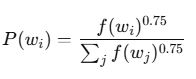


In [ ]:
k = 5  #For each positive pair (center, context) we sample k negative words.

In [ ]:
freq_list = []

for index in range(len(idx2word)):
    word = idx2word[index]
    count = updated_word_count[word]
    freq_list.append(count)

In [ ]:
for index in range(5):
  print(f"Word: {idx2word[index]}, Count: {updated_word_count[idx2word[index]]}")

Word: the, Count: 159625
Word: of, Count: 69265
Word: and, Count: 60523
Word: in, Count: 53869
Word: to, Count: 48198


**Convert to PyTorch Tensor**

In [ ]:
freq_tensor = torch.tensor(freq_list, dtype=torch.float32)

In [ ]:
freq_tensor.shape

torch.Size([29780])

In [ ]:
freq_tensor = freq_tensor ** 0.75   # f(w)**3/4

**Normalize**

In [ ]:
neg_sampling_probs = freq_tensor / freq_tensor.sum()

In [ ]:
neg_sampling_probs.sum() == 1

tensor(True)

In [ ]:
neg_sampling_probs.shape

torch.Size([29780])

**Sampling Negatives During Training**

In [ ]:
neg_indices = torch.multinomial(
    neg_sampling_probs,
    num_samples = k,
    replacement = True
)


In [ ]:
samples = torch.multinomial(neg_sampling_probs, 10000, replacement=True)


In [ ]:
sample_counter = Counter(samples.tolist())  # converts tensor to Python list of integers

In [ ]:
sample_counter.most_common(10)

[(0, 190),
 (1, 109),
 (3, 88),
 (2, 84),
 (4, 81),
 (5, 81),
 (6, 50),
 (8, 44),
 (10, 38),
 (7, 37)]

#**Skipgram Architecture**

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()

        self.input_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embed_dim)

        nn.init.normal_(self.input_embeddings.weight, mean=0, std=0.01)
        nn.init.normal_(self.output_embeddings.weight, mean=0, std=0.01)

    def forward(self, center_idx, pos_idx, neg_indices):

        center_vec = self.input_embeddings(center_idx)      # (d,)
        pos_vec = self.output_embeddings(pos_idx)           # (d,)
        neg_vecs = self.output_embeddings(neg_indices)      # (k, d)

        pos_score = torch.dot(center_vec, pos_vec)
        neg_score = torch.matmul(neg_vecs, center_vec)      # (k,)

        loss_pos = F.logsigmoid(pos_score)
        loss_neg = F.logsigmoid(-neg_score).sum()

        loss = -(loss_pos + loss_neg)

        return loss


**Batched SkipGram Model**

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()

        self.input_embeddings = nn.Embedding(vocab_size, embed_dim)
        self.output_embeddings = nn.Embedding(vocab_size, embed_dim)

        nn.init.normal_(self.input_embeddings.weight, mean=0, std=0.01)
        nn.init.normal_(self.output_embeddings.weight, mean=0, std=0.01)

    def forward(self, center_idxs, pos_idxs, neg_idxs):
        """
        center_idxs: (B,)
        pos_idxs:    (B,)
        neg_idxs:    (B, k)
        """

        # (B, d)
        center_vecs = self.input_embeddings(center_idxs)

        # (B, d)
        pos_vecs = self.output_embeddings(pos_idxs)

        # (B, k, d)
        neg_vecs = self.output_embeddings(neg_idxs)

        # Positive scores → (B,)
        pos_scores = torch.sum(center_vecs * pos_vecs, dim=1)

        # Negative scores → (B, k)
        neg_scores = torch.sum(
            neg_vecs * center_vecs.unsqueeze(1),
            dim=2
        )

        # Loss
        loss_pos = F.logsigmoid(pos_scores)
        loss_neg = F.logsigmoid(-neg_scores).sum(dim=1)

        loss = -(loss_pos + loss_neg)

        return loss.mean()


**Precompute Positive Pairs (Once)**

In [ ]:
pairs = []

window_size = 3

for sentence in indexed_corpus:
    for i, center in enumerate(sentence):
        start = max(0, i - window_size)
        end = min(len(sentence), i + window_size + 1)

        for j in range(start, end):
            if i != j:
                pairs.append((center, sentence[j]))

print("Total training pairs:", len(pairs))


Total training pairs: 3164394


#**Training**

In [ ]:
neg_indices.dtype == torch.long


True

In [ ]:
# vocab_size = len(idx2word)
# embed_dim = 100 # hyperparameter
# num_epochs = 1

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

**Training loop vanilla**

In [ ]:
# model = SkipGram(vocab_size, embed_dim).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(num_epochs):

#     total_loss = 0
#     pair_count = 0

#     for center, context in generate_context_pairs(indexed_corpus, window):

#         center_tensor = torch.tensor(center, dtype=torch.long).to(device)
#         context_tensor = torch.tensor(context, dtype=torch.long).to(device)

#         neg_indices = torch.multinomial(neg_sampling_probs, k, replacement=True).to(device)

#         # optional exclusion logic here

#         loss = model(center_tensor, context_tensor, neg_indices)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         pair_count += 1

#     print(f"Epoch {epoch+1} | Avg Loss: {total_loss/pair_count:.4f}")

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
vocab_size = len(idx2word)
embed_dim = 100 # hyperparameter
num_epochs = 10
batch_size = 256

model = SkipGram(vocab_size, embed_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
neg_sampling_probs = neg_sampling_probs.to(device)


In [ ]:
# for epoch in range(num_epochs):

#     random.shuffle(pairs)

#     total_loss = 0
#     num_batches = 0

#     for i in range(0, len(pairs), batch_size):

#         batch = pairs[i:i+batch_size]

#         centers = torch.tensor(
#             [p[0] for p in batch],
#             dtype=torch.long,
#             device=device
#         )

#         contexts = torch.tensor(
#             [p[1] for p in batch],
#             dtype=torch.long,
#             device=device
#         )

#         # Sample negatives directly on GPU
#         neg_idxs = torch.multinomial(
#             neg_sampling_probs,
#             num_samples=len(batch) * k,
#             replacement=True
#         ).view(len(batch), k)

#         loss = model(centers, contexts, neg_idxs)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         num_batches += 1

#     print(f"Epoch {epoch+1} | Avg Loss: {total_loss / num_batches:.4f}")


**Filtering top 5000 Nouns and Adjectives**

In [ ]:
import json
import nltk
print("NLTK library imported.")

NLTK library imported.


In [ ]:
nltk.download('averaged_perceptron_tagger')
print("NLTK 'averaged_perceptron_tagger' downloaded.")

NLTK 'averaged_perceptron_tagger' downloaded.


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Get all words from idx2word
all_words = [idx2word[i] for i in range(vocab_size)]

# Ensure the specific tagger resource is downloaded for nltk.pos_tag
nltk.download('averaged_perceptron_tagger_eng')

# Perform POS tagging
pos_tags = nltk.pos_tag(all_words)

# Define target POS tags for nouns and adjectives
target_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'}

# Filter words based on POS tags
filtered_nouns_adjectives = [word for word, tag in pos_tags if tag in target_pos]

# Sort filtered words by frequency and select the top 5000
# Ensure word is in updated_word_count to avoid KeyError for very rare words, though it shouldn't happen here.
top_5000_nouns_adjectives = sorted(
    [word for word in filtered_nouns_adjectives if word in updated_word_count],
    key=lambda w: updated_word_count[w],
    reverse=True
)[:5000]

print(f"Number of top nouns and adjectives selected: {len(top_5000_nouns_adjectives)}")

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Number of top nouns and adjectives selected: 5000


**Training loop for Converting embeddings into json file**

Training for 10 epochs

Save top 5000 embeddings(Verbs and Adjectives) as json file

In [ ]:
import json
import numpy as np
from sklearn.decomposition import PCA

# Re-defining variables that might not be in scope if the cell is run in isolation
vocab_size = len(idx2word)
embed_dim = 100 # hyperparameter
num_epochs = 10
batch_size = 256


# The training loop
for epoch in range(num_epochs):

    random.shuffle(pairs)

    total_loss = 0
    num_batches = 0

    for i in range(0, len(pairs), batch_size):

        batch = pairs[i:i+batch_size]

        centers = torch.tensor(
            [p[0] for p in batch],
            dtype=torch.long,
            device=device
        )

        contexts = torch.tensor(
            [p[1] for p in batch],
            dtype=torch.long,
            device=device
        )

        # Sample negatives directly on GPU
        neg_idxs = torch.multinomial(
            neg_sampling_probs,
            num_samples=len(batch) * k,
            replacement=True
        ).view(len(batch), k)

        loss = model(centers, contexts, neg_idxs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    print(f"Epoch {epoch+1} | Avg Loss: {total_loss / num_batches:.4f}")

    if (epoch + 1) in [2, 5, 10]:
        current_embeddings = model.input_embeddings.weight.detach().cpu().numpy()

        # 1. Filter and Prepare Words
        filtered_indices = [word2idx[w] for w in top_5000_nouns_adjectives if w in word2idx]
        words_list = [idx2word[idx] for idx in filtered_indices]
        vecs = current_embeddings[filtered_indices]

        # 2. L2-normalize
        norms = np.linalg.norm(vecs, axis=1, keepdims=True)
        vecs_normed = vecs / np.where(norms == 0, 1e-8, norms)

        # 3. PCA to 2D
        pca = PCA(n_components=2, random_state=42)
        vecs_2d = pca.fit_transform(vecs_normed)

        # 4. PACKAGE AS DICTIONARIES (Crucial for the HTML lookup)
        output_payload = {
            "epoch": epoch + 1,
            "vocab_size": len(words_list),
            "embed_dim": embed_dim,
            "pca_variance": pca.explained_variance_ratio_.tolist(),
            "words": words_list,
            # Map word -> vector
            "embeddings": {w: vecs_normed[i].tolist() for i, w in enumerate(words_list)},
            # Map word -> [x, y]
            "coords_2d": {w: vecs_2d[i].tolist() for i, w in enumerate(words_list)}
        }

        # 5. Save (using separators for smaller file size)
        output_json_path = f'embeddings_epoch{epoch+1}.json'
        with open(output_json_path, 'w') as f:
            json.dump(output_payload, f, separators=(",", ":"))

        print(f"✅ Saved {output_json_path} for {len(words_list)} words.")

Epoch 1 | Avg Loss: 2.7062
Epoch 2 | Avg Loss: 2.3077
✅ Saved embeddings_epoch2.json for 5000 words.
Epoch 3 | Avg Loss: 2.0196
Epoch 4 | Avg Loss: 1.8137
Epoch 5 | Avg Loss: 1.6730
✅ Saved embeddings_epoch5.json for 5000 words.
Epoch 6 | Avg Loss: 1.5796
Epoch 7 | Avg Loss: 1.5151
Epoch 8 | Avg Loss: 1.4689
Epoch 9 | Avg Loss: 1.4344
Epoch 10 | Avg Loss: 1.4070
✅ Saved embeddings_epoch10.json for 5000 words.


In [ ]:
# for epoch in range(num_epochs):

#     random.shuffle(pairs)

#     total_loss = 0
#     num_batches = 0

#     for i in range(0, len(pairs), batch_size):

#         batch = pairs[i:i+batch_size]

#         centers = torch.tensor(
#             [p[0] for p in batch],
#             dtype=torch.long,
#             device=device
#         )

#         contexts = torch.tensor(
#             [p[1] for p in batch],
#             dtype=torch.long,
#             device=device
#         )

#         # Sample negatives directly on GPU
#         neg_idxs = torch.multinomial(
#             neg_sampling_probs,
#             num_samples=len(batch) * k,
#             replacement=True
#         ).view(len(batch), k)

#         loss = model(centers, contexts, neg_idxs)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         num_batches += 1

#     print(f"Epoch {epoch+1} | Avg Loss: {total_loss / num_batches:.4f}")

#     if (epoch + 1) in [2, 5, 10]:
#         current_embeddings = model.input_embeddings.weight.detach().cpu().numpy()
#         small_word_embeddings_dict = {}
#         for word in top_5000_nouns_adjectives:
#             if word in word2idx: # Ensure the word exists in the vocabulary
#                 word_idx = word2idx[word]
#                 small_word_embeddings_dict[word] = current_embeddings[word_idx].tolist()

#         output_json_path_small = f'filtered_embeddings_epoch{epoch+1}.json'
#         with open(output_json_path_small, 'w') as f:
#             json.dump(small_word_embeddings_dict, f, indent=4)
#         print(f"Filtered embeddings (top {len(small_word_embeddings_dict)} nouns/adjectives) saved to {output_json_path_small} at epoch {epoch+1}.")

#**Model Evaluation**

In [ ]:
embeddings = model.input_embeddings.weight.detach()
norm_embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)


In [ ]:
def get_similarity(word1, word2):
    if word1 not in word2idx or word2 not in word2idx:
        return None

    idx1 = word2idx[word1]
    idx2 = word2idx[word2]

    return torch.dot(
        norm_embeddings[idx1],
        norm_embeddings[idx2]
    ).item()


In [ ]:
get_similarity('player','game')

0.4443729519844055

**🧠 Implement Nearest Neighbor**

In [ ]:
def get_nearest(word, top_k=10):
    if word not in word2idx:
        return []

    idx = word2idx[word]
    query_vec = norm_embeddings[idx]

    similarities = torch.matmul(norm_embeddings, query_vec)

    top_indices = torch.topk(similarities, top_k + 1).indices.tolist()

    return [idx2word[i] for i in top_indices if i != idx][:top_k]


In [ ]:
print(f"Nearest Neighbours of gaming: {get_nearest("gaming")}")
print(f"Nearest Neighbours of monarchs: {get_nearest("monarchs")}")
print(f"Nearest Neighbours of music: {get_nearest("music")}")

Nearest Neighbours of gaming: ['sequel', 'famitsu', 'informer', 'visuals', 'reprise', 'puzzles', 'esports', 'dota', 'pc', 'gameplay.']
Nearest Neighbours of monarchs: ['parthian', 'constantinople', 'greeks', "odaenathus'", 'siyah', 'arabic:', 'palmyrene', 'rebellion.', 'rulers', 'pope,']
Nearest Neighbours of music: ['influences,', 'nelly', 'kawai', 'guy.', 'repertoire.', 'youtube.', 'publishing.', 'month:', 'jazz,', 'life"']


**Test Analogy**

In [ ]:
def analogy(a, b, c, top_k=5):
    if a not in word2idx or b not in word2idx or c not in word2idx:
        return []

    vec = norm_embeddings[word2idx[a]] - \
          norm_embeddings[word2idx[b]] + \
          norm_embeddings[word2idx[c]]

    similarities = torch.matmul(norm_embeddings, vec)
    top_indices = torch.topk(similarities, top_k).indices.tolist()

    return [idx2word[i] for i in top_indices]


In [ ]:
#analogy("king", "man", "woman")
analogy("sony", "shimomura", "video")

['video', 'sony', '"rockstar', '"fantasy"', 'online']

#**PCA Visualization**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Circle
import numpy as np

In [ ]:
target_words = ['gaming', 'monarchs', 'music']
words_to_plot = []

# Collect target words and their nearest neighbors from the user's provided lists

# Gaming and its neighbors
words_to_plot.append('gaming')
gaming_neighbors = ['multiplayer', 'flick', 'lucasfilm', 'freaks', "ign's", 'game",', 'blackley', 'scrolling', 'downloadable', 'games,']
for neighbor in gaming_neighbors:
    if neighbor in word2idx and neighbor not in words_to_plot:
        words_to_plot.append(neighbor)

# Monarchs and its neighbors
words_to_plot.append('monarchs')
monarchs_neighbors = ['assyrian', '1287,', 'copán', 'rulers', 'palmyra', 'revolted', 'esarhaddon', 'king', 'nubia', 'successors']
for neighbor in monarchs_neighbors:
    if neighbor in word2idx and neighbor not in words_to_plot:
        words_to_plot.append(neighbor)

# Music and its neighbors
words_to_plot.append('music')
music_neighbors = ["mtv's", 'awards', 'christmas"', 'video,', "shimomura's", 'album."', 'recordings', '"30', 'musical', 'mccartney,']
for neighbor in music_neighbors:
    if neighbor in word2idx and neighbor not in words_to_plot:
        words_to_plot.append(neighbor)

# Remove any potential duplicate words from the list
words_to_plot = list(set(words_to_plot))

# Create a list of indices for the words to plot
plot_indices = [word2idx[word] for word in words_to_plot if word in word2idx] # Ensure word exists in vocab

# Retrieve the normalized embeddings for these indices
specific_embeddings = norm_embeddings[plot_indices]

print(f"Words collected for plotting: {len(words_to_plot)}")
print(f"Shape of specific embeddings: {specific_embeddings.shape}")

Words collected for plotting: 33
Shape of specific embeddings: torch.Size([33, 100])


In [ ]:
pca_specific = PCA(n_components=2)
specific_2d = pca_specific.fit_transform(specific_embeddings.cpu().numpy())

print(f"Shape of 2D specific embeddings: {specific_2d.shape}")

Shape of 2D specific embeddings: (33, 2)


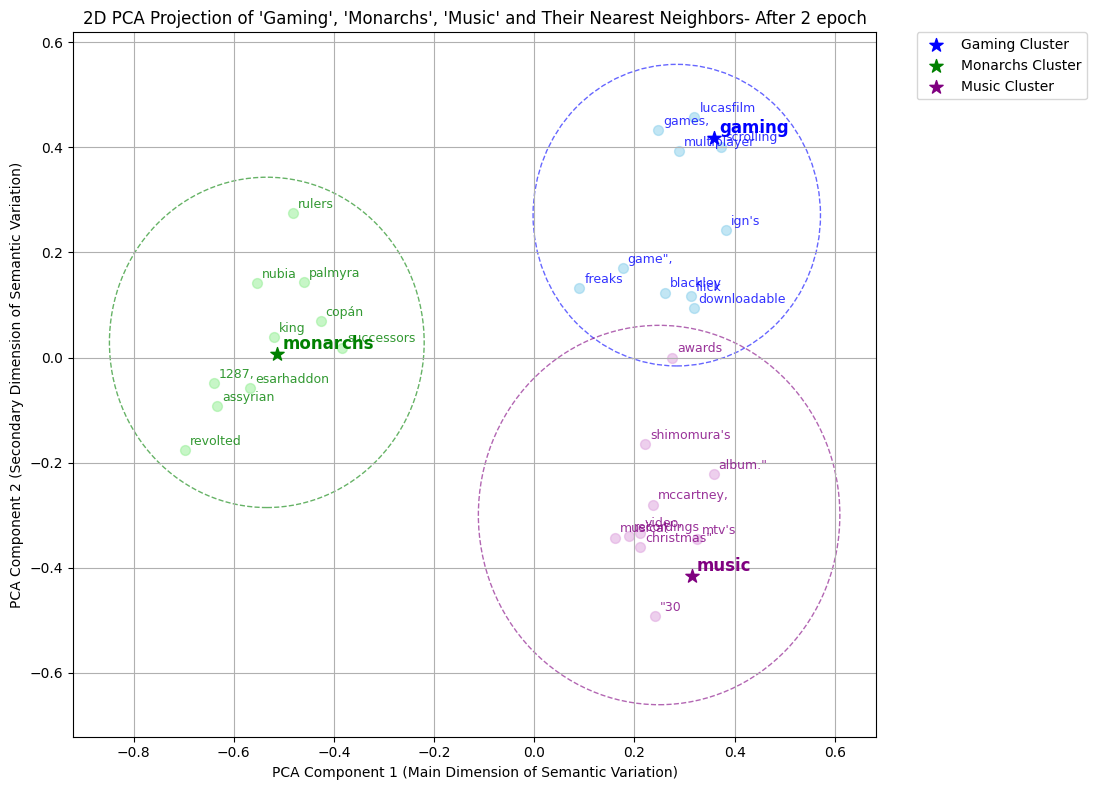

In [ ]:
# Re-define the target words and their provided neighbors (for self-containment in this cell)
target_words_list = ['gaming', 'monarchs', 'music']
gaming_neighbors_list = ['multiplayer', 'flick', 'lucasfilm', 'freaks', "ign's", 'game",', 'blackley', 'scrolling', 'downloadable', 'games,']
monarchs_neighbors_list = ['assyrian', '1287,', 'copán', 'rulers', 'palmyra', 'revolted', 'esarhaddon', 'king', 'nubia', 'successors']
music_neighbors_list = ["mtv's", 'awards', 'christmas"', 'video,', "shimomura's", 'album."', 'recordings', '"30', 'musical', 'mccartney,']

# Combine all words for plotting and categorization
all_words_for_plot = list(set(
    target_words_list +
    gaming_neighbors_list +
    monarchs_neighbors_list +
    music_neighbors_list
))

# Filter to only words existing in word2idx
all_words_for_plot = [word for word in all_words_for_plot if word in word2idx]

# Get indices and embeddings for these words
plot_indices_temp = [word2idx[word] for word in all_words_for_plot]
specific_embeddings_temp = norm_embeddings[plot_indices_temp]

# Re-apply PCA for just these words to get their 2D coordinates
pca_specific_temp = PCA(n_components=2)
specific_2d_temp = pca_specific_temp.fit_transform(specific_embeddings_temp.cpu().numpy())

# Create a mapping from word to its 2D coordinates for easy lookup
word_to_coords = {word: specific_2d_temp[i] for i, word in enumerate(all_words_for_plot)}

plt.figure(figsize=(15, 8)) # Adjusted figsize for 1200x644 pixels at 100 DPI

# Define colors for clusters and target words
colors = {
    'gaming': {'cluster': 'skyblue', 'target': 'blue'},
    'monarchs': {'cluster': 'lightgreen', 'target': 'green'},
    'music': {'cluster': 'plum', 'target': 'purple'}
}

clusters = {
    'gaming': gaming_neighbors_list,
    'monarchs': monarchs_neighbors_list,
    'music': music_neighbors_list
}

for main_word, neighbors_list in clusters.items():
    current_cluster_words = [main_word] + [n for n in neighbors_list if n in word_to_coords]
    if not current_cluster_words:
        continue

    cluster_coords = np.array([word_to_coords[w] for w in current_cluster_words if w in word_to_coords])

    if cluster_coords.shape[0] == 0:
        continue

    # Calculate centroid
    centroid = np.mean(cluster_coords, axis=0)

    # Calculate max distance from centroid (for radius)
    radius = 0
    if cluster_coords.shape[0] > 1: # Need at least 2 points for a meaningful radius
        max_dist = np.max(np.linalg.norm(cluster_coords - centroid, axis=1))
        radius = max_dist * 1.2 # Add some padding to the radius
    elif cluster_coords.shape[0] == 1: # Single point, just a small radius
        radius = 0.05 # A small default radius


    # Draw dotted circle
    if radius > 0:
        circle = Circle(centroid, radius, color=colors[main_word]['target'], fill=False, linestyle='--', alpha=0.6)
        plt.gca().add_patch(circle)

    # Plot neighbors
    for word in neighbors_list:
        if word in word_to_coords:
            x, y = word_to_coords[word][0], word_to_coords[word][1]
            plt.scatter(x, y, color=colors[main_word]['cluster'], s=50, alpha=0.5, label='_nolegend_')
            # Updated annotation for readability
            plt.annotate(word, (x + 0.01, y + 0.01), fontsize=9, color=colors[main_word]['target'], alpha=0.8)

    # Plot main word (on top, larger marker)
    if main_word in word_to_coords:
        x, y = word_to_coords[main_word][0], word_to_coords[main_word][1]
        plt.scatter(x, y, color=colors[main_word]['target'], s=100, marker='*', zorder=5, label=f'{main_word.capitalize()} Cluster')
        plt.annotate(main_word, (x + 0.01, y + 0.01), fontsize=12, color=colors[main_word]['target'], weight='bold')


plt.xlabel("PCA Component 1 (Main Dimension of Semantic Variation)")
plt.ylabel("PCA Component 2 (Secondary Dimension of Semantic Variation)")
plt.title("2D PCA Projection of 'Gaming', 'Monarchs', 'Music' and Their Nearest Neighbors- After 2 epoch")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()